# Intro

I'm trying to learn the very basics with this exercise. My goal is to train a linear regression model with a subset of columns from this interesting dataset in order to predict the value of a used car.

Any help or advice is welcome!!!

### Changelist

* rewritten all the notebook
* added name length feature
* better study on the data
* used seaborn to plot
* added random forest and xgboost algorithms

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, preprocessing, svm
from sklearn.preprocessing import StandardScaler, Normalizer
import math
import matplotlib
import seaborn as sns


### Useful functions

In [2]:
def category_values(dataframe, categories):
    for c in categories:
        print('\n', dataframe.groupby(by=c)[c].count().sort_values(ascending=False))
        print('Nulls: ', dataframe[c].isnull().sum())

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )



# Preparing data

## Reading from file

Just reading the file and printing some lines.

In [3]:
# df = pd.read_csv('../input/autos.csv', sep=',', header=0, encoding='cp1252')
df = pd.read_csv('autos.csv.gz', sep=',', header=0, compression='gzip',encoding='cp1252')
df.sample(10)

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
10039,2016-03-08 18:47:51,VW_T3_Doka,privat,Angebot,0,test,bus,1987,manuell,0,NaN,150000,0,diesel,volkswagen,ja,2016-03-08 00:00:00,0,2763,2016-04-07 12:17:42
51553,2016-03-20 14:38:34,BMW_525i_touring,privat,Angebot,2999,test,kombi,2002,automatik,192,5er,150000,2,benzin,bmw,nein,2016-03-20 00:00:00,0,91346,2016-04-06 17:15:55
252212,2016-03-14 17:55:47,BMW_E46_330i_/_Vanos__Lack__Bremsscheiben_VA__...,privat,Angebot,5500,test,NaN,2002,manuell,231,3er,150000,0,NaN,bmw,nein,2016-03-14 00:00:00,0,48488,2016-04-06 14:15:46
139741,2016-03-24 22:52:53,BMW_118d_DPF,privat,Angebot,9500,control,limousine,2009,manuell,143,1er,100000,10,diesel,bmw,nein,2016-03-24 00:00:00,0,97828,2016-03-25 06:42:11
299305,2016-03-30 22:30:55,Audi_A4_Kombi,privat,Angebot,6750,control,kombi,2005,manuell,140,a4,150000,9,diesel,audi,NaN,2016-03-30 00:00:00,0,61381,2016-04-05 14:47:25
287866,2016-04-04 23:52:57,Honda_CRX_1.6_ESi,privat,Angebot,4499,control,coupe,1994,manuell,125,cr_reihe,150000,1,benzin,honda,nein,2016-04-04 00:00:00,0,59457,2016-04-07 09:15:19
344860,2016-03-22 15:57:44,Mazda_3_2_3_MZR_MPS,privat,Angebot,7850,control,limousine,2008,manuell,260,3_reihe,125000,5,benzin,mazda,nein,2016-03-22 00:00:00,0,26919,2016-04-06 06:45:05
220942,2016-04-02 18:47:48,Volvo_XC70__Leder_Scheckheft__Top_Zustand__Vov...,privat,Angebot,17900,control,kombi,2011,manuell,163,xc_reihe,150000,6,diesel,volvo,nein,2016-04-02 00:00:00,0,46519,2016-04-02 18:47:48
62222,2016-03-20 20:51:15,Smart_pure___GUT_GEPFLEGT,privat,Angebot,2200,test,kleinwagen,2003,NaN,50,fortwo,70000,11,benzin,smart,nein,2016-03-20 00:00:00,0,96479,2016-03-23 07:48:32
286541,2016-03-10 13:40:47,Ford_Ka_1.2_Titanium___Wenig_Kilometer_!,privat,Angebot,4900,test,kleinwagen,2009,manuell,69,ka,50000,11,benzin,ford,nein,2016-03-10 00:00:00,0,68789,2016-04-03 07:44:55


Let's see some info from numeric fields

In [4]:
df.describe()


,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000,371528.0,371528.00000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445,0.0,50820.66764
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412,0.0,25799.08247
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.00000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000,0.0,30459.00000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.00000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000,0.0,71546.00000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.00000


## Dropping some useless columns

Some column can already be dropped.

In [5]:
print(df.seller.unique())
print(df.offerType.unique())
print(df.abtest.unique())
print(df.nrOfPictures.unique())

['privat' 'gewerblich']
['Angebot' 'Gesuch']
['test' 'control']
[0]


Seller has only one value, while offerType and abtest has no relevance for the analysis. So far, I still don't know how to use the `dateCrawled` column.

Therefore I modify the dataframe dropping all those features.

I remove `lastSeen`, `dateCreated` and `postalCode` as well as I don't think they will be useful for a price prediction.

In [6]:
df.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 'nrOfPictures', 'lastSeen', 'postalCode', 'dateCreated'], axis='columns', inplace=True)


## Cleaning data

Cleaning data from duplicates, NaNs and selecting reasonable ranges for columns


In [7]:
print("Too new: %d" % df.loc[df.yearOfRegistration >= 2017].count()['name'])
print("Too old: %d" % df.loc[df.yearOfRegistration < 1950].count()['name'])
print("Too cheap: %d" % df.loc[df.price < 100].count()['name'])
print("Too expensive: " , df.loc[df.price > 150000].count()['name'])
print("Too few km: " , df.loc[df.kilometer < 5000].count()['name'])
print("Too many km: " , df.loc[df.kilometer > 200000].count()['name'])
print("Too few PS: " , df.loc[df.powerPS < 10].count()['name'])
print("Too many PS: " , df.loc[df.powerPS > 500].count()['name'])
print("Fuel types: " , df['fuelType'].unique())
#print("Offer types: " , df['offerType'].unique())
#print("Sellers: " , df['seller'].unique())
print("Damages: " , df['notRepairedDamage'].unique())
#print("Pics: " , df['nrOfPictures'].unique()) # nrOfPictures : number of pictures in the ad (unfortunately this field contains everywhere a 0 and is thus useless (bug in crawler!) )
#print("Postale codes: " , df['postalCode'].unique())
print("Vehicle types: " , df['vehicleType'].unique())
print("Brands: " , df['brand'].unique())

# Cleaning data
#valid_models = df.dropna()

#### Removing the duplicates
dedups = df.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])

#### Removing the outliers
dedups = dedups[
        (dedups.yearOfRegistration <= 2016) 
      & (dedups.yearOfRegistration >= 1950) 
      & (dedups.price >= 100) 
      & (dedups.price <= 150000) 
      & (dedups.powerPS >= 10) 
      & (dedups.powerPS <= 500)]

print("-----------------\nData kept for analisys: %d percent of the entire set\n-----------------" % (100 * dedups['name'].count() / df['name'].count()))


Too new: 14680
Too old: 289
Too cheap: 13320
Too expensive:  232
Too few km:  0
Too many km:  0
Too few PS:  41040
Too many PS:  835
Fuel types:  ['benzin' 'diesel' nan 'lpg' 'andere' 'hybrid' 'cng' 'elektro']
Damages:  [nan 'ja' 'nein']
Vehicle types:  [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
Brands:  ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda' 'nissan'
 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat' 'mini'
 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'porsche' 'toyota' 'chevrolet'
 'dacia' 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'rover'
 'land_rover' 'lada']
-----------------
Data kept for analisys: 81 percent of the entire set
-----------------


## Working on the `null` values

Checking if theree are NaNs to fix or drop

In [8]:
dedups.isnull().sum()

name                       0
price                      0
vehicleType            10818
yearOfRegistration         0
gearbox                 5260
powerPS                    0
model                  11347
kilometer                  0
monthOfRegistration        0
fuelType               15400
brand                      0
notRepairedDamage      42124
dtype: int64

Some decisions to take for the nulls in the following fields: vehicleType (37422 nulls), gearbox (19803 nulls), model (20288 nulls), fuelType (33081 nulls), notRepairedDamage (70770 nulls).

### `model`-`brand`-`vehicleType`
If we have the `model` we could determine the `brand` and the `vehicleType` calculating the mode for the corresponding fields in the rest of the dataset. The opposite combinations are not true. So I think the actions should be:

| `vehicleType` | `brand` | `model` | Action 
| ---           | ---     | ---     |
| `null`        |  `null` | [value] | Set the other fields
| `null`        | [value] | `null`  | Delete
| [value]       |  `null` | `null`  | Delete

__So far, I'll drop all the NaNs in these 3 fields.__

### `notRepairedDamage`
Those with null `notRepairedDamage` field could be set to "`not-declared`" value for example.

### `fuelType`
Null `fuelType`s could be set to "`not-declared`" value again.

### `gearbox`
Null `fuelType`s could be set to "`not-declared`" value again.



In [9]:
dedups['notRepairedDamage'].fillna(value='not-declared', inplace=True)
dedups['fuelType'].fillna(value='not-declared', inplace=True)
dedups['gearbox'].fillna(value='not-declared', inplace=True)
dedups['vehicleType'].fillna(value='not-declared', inplace=True)
dedups['model'].fillna(value='not-declared', inplace=True)

Checking if all the nulls have been filled or dropped.

In [10]:
dedups.isnull().sum()

name                   0
price                  0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

OK, we're clear. Let's do some visualization now.

## Visualizations
### Categories distribution
Let's see some charts to understand how data is distributed across the categories

gearbox
manuell         231997
automatik        66876
not-declared      5260
Name: gearbox, dtype: int64


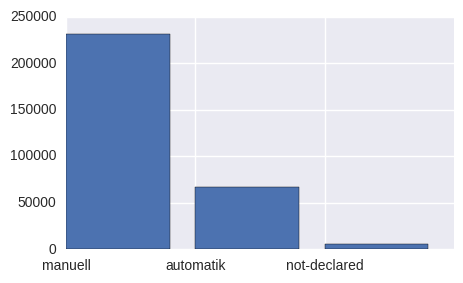

model
golf            24846
andere          21733
3er             17704
not-declared    11347
polo            10477
Name: model, dtype: int64


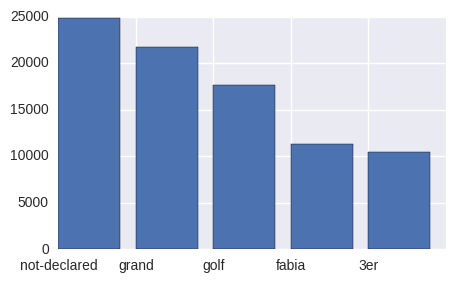

brand
volkswagen       64853
bmw              34441
opel             31757
mercedes_benz    29562
audi             27984
Name: brand, dtype: int64


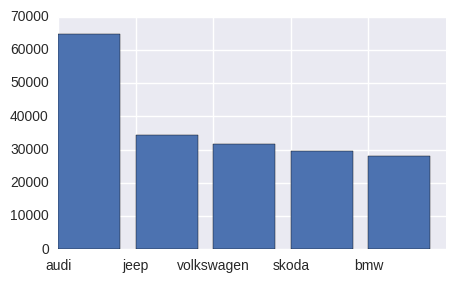

vehicleType
limousine     84843
kleinwagen    68415
kombi         59863
bus           26986
cabrio        20921
Name: vehicleType, dtype: int64


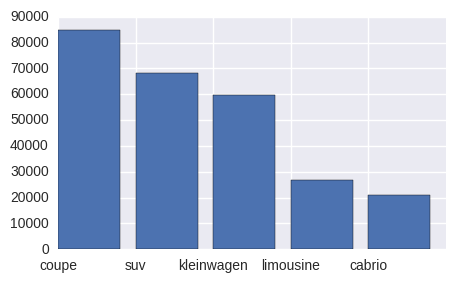

fuelType
benzin          189919
diesel           93299
not-declared     15400
lpg               4646
cng                474
Name: fuelType, dtype: int64


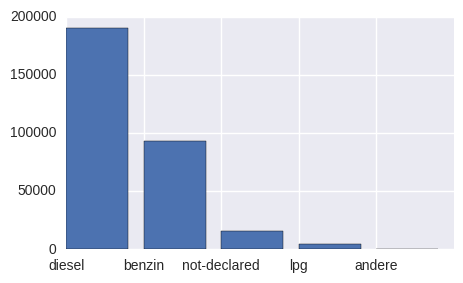

notRepairedDamage
nein            233684
not-declared     42124
ja               28325
Name: notRepairedDamage, dtype: int64


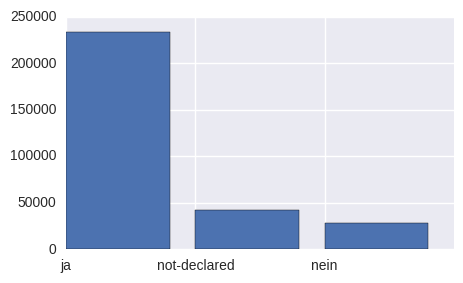

In [11]:
categories = ['gearbox', 'model', 'brand', 'vehicleType', 'fuelType', 'notRepairedDamage']

for i, c in enumerate(categories):
    v = dedups[c].unique()
    
    g = dedups.groupby(by=c)[c].count().sort_values(ascending=False)
    r = range(min(len(v), 5))

    print( g.head())
    plt.figure(figsize=(5,3))
    plt.bar(r, g.head()) 
    plt.xticks(r, v)
    plt.show()

### Feature engineering

Adding the name length to see how much does a long description influence the price

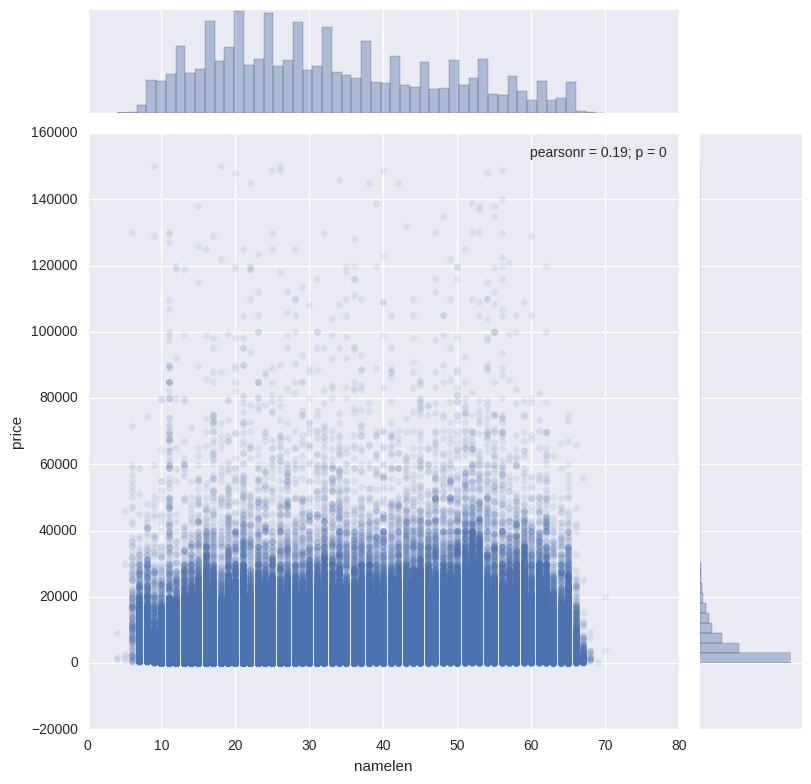

In [12]:
dedups['namelen'] = [min(70, len(n)) for n in dedups['name']]

ax = sns.jointplot(x='namelen', 
                   y='price',
                   data=dedups[['namelen','price']], 
#                   data=dedups[['namelen','price']][dedups['model']=='golf'], 
                    alpha=0.1, 
                    size=8)


It seems that a name length between 15 and 30 characters is better for the sale price. An explanation could be that a longer name includes more optionals and accessories and therefore the price is obviously higher.
Very short and very long names do not work well.

In [13]:
labels = ['name', 'gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(dedups[l])
    tr = les[l].transform(dedups[l]) 
    dedups.loc[:, l + '_feat'] = pd.Series(tr, index=dedups.index)

labeled = dedups[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'
                        ,'monthOfRegistration'
                        , 'namelen'] 
                    + [x+"_feat" for x in labels]]


In [14]:
len(labeled['name_feat'].unique()) / len(labeled['name_feat'])

0.6224184813880769

Labels for the name column account for 62% of the total. I think it's too much, so I remove the feature.

In [15]:
labeled.drop(['name_feat'], axis='columns', inplace=True)

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Correlations
Let's see how features are correlated each other and, more important, with the price.

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,namelen,gearbox_feat,notRepairedDamage_feat,model_feat,brand_feat,fuelType_feat,vehicleType_feat
price,1.000000,0.385264,0.573037,-0.444440,0.044782,0.186254,-0.297746,-0.002440,-0.012514,-0.105694,0.055978,-0.010906
yearOfRegistration,0.385264,1.000000,0.186486,-0.333933,0.044390,0.158798,-0.094694,-0.015699,0.041173,-0.044526,0.142402,0.058958
powerPS,0.573037,0.186486,1.000000,-0.014727,0.038635,0.106243,-0.447440,-0.022761,-0.132902,-0.310254,0.086305,0.112243
kilometer,-0.444440,-0.333933,-0.014727,1.000000,-0.016177,-0.105892,0.035524,0.005072,-0.023827,-0.026645,0.115204,0.043183
monthOfRegistration,0.044782,0.044390,0.038635,-0.016177,1.000000,0.044338,-0.049902,-0.050227,-0.009070,-0.012156,-0.035938,-0.004369
namelen,0.186254,0.158798,0.106243,-0.105892,0.044338,1.000000,-0.150795,-0.008167,0.078520,0.100056,0.043864,-0.026672
gearbox_feat,-0.297746,-0.094694,-0.447440,0.035524,-0.049902,-0.150795,1.000000,0.038948,0.046971,0.125735,-0.057441,-0.092224
notRepairedDamage_feat,-0.002440,-0.015699,-0.022761,0.005072,-0.050227,-0.008167,0.038948,1.000000,0.017825,0.016474,0.061819,0.027220
model_feat,-0.012514,0.041173,-0.132902,-0.023827,-0.009070,0.078520,0.046971,0.017825,1.000000,0.472098,0.049058,-0.136196
brand_feat,-0.105694,-0.044526,-0.310254,-0.026645,-0.012156,0.100056,0.125735,0.016474,0.472098,1.000000,-0.023840,-0.102601


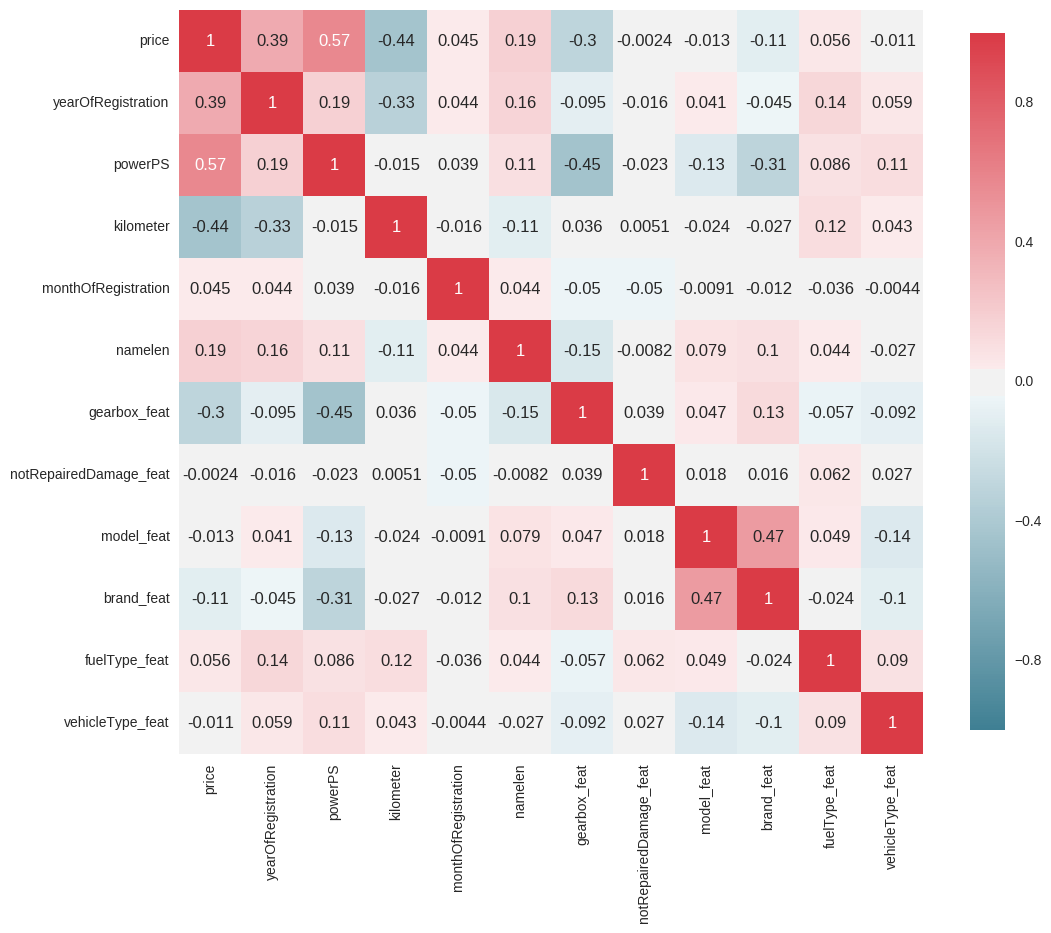

In [16]:
plot_correlation_map(labeled)
labeled.corr()

This is the list of the most influencing features for the price

In [17]:
labeled.corr().loc[:,'price'].abs().sort_values(ascending=False)[1:]

powerPS                   0.573037
kilometer                 0.444440
yearOfRegistration        0.385264
gearbox_feat              0.297746
namelen                   0.186254
brand_feat                0.105694
fuelType_feat             0.055978
monthOfRegistration       0.044782
model_feat                0.012514
vehicleType_feat          0.010906
notRepairedDamage_feat    0.002440
Name: price, dtype: float64

I don't know why the model does not influence the car price more...

# Playing with different models


## Prepare data for training
Here I split the dataset in train and validation data and tune the right-skewed sale price column.


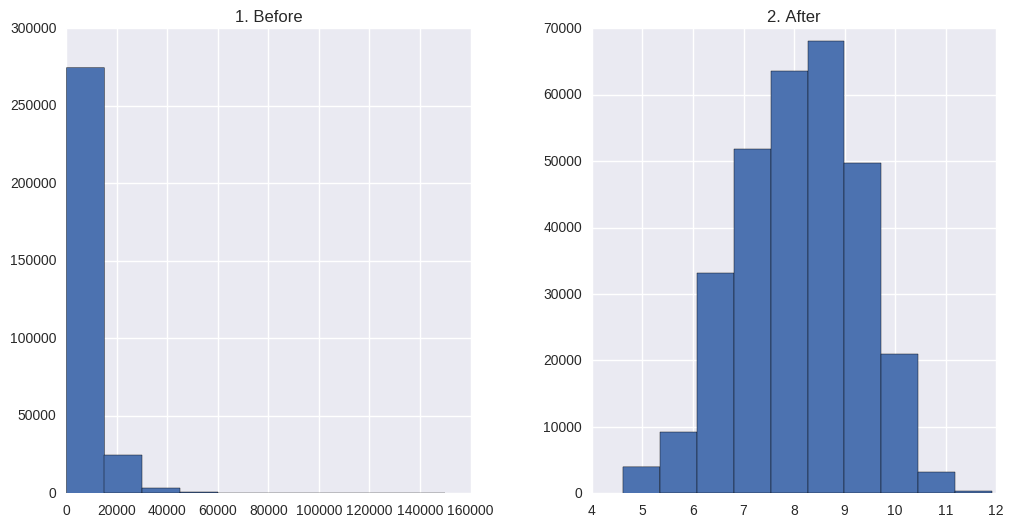

In [18]:

Y = labeled['price']
X = labeled.drop(['price'], axis='columns', inplace=False)


matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"1. Before":Y, "2. After":np.log1p(Y)})
prices.hist()

Y = np.log1p(Y)

### Basic imports and functions

Trying with some model from scikit learn: LinearRegression, LR with L2 regularization and others.

In [19]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score, train_test_split

def cv_rmse(model, x, y):
    r = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return r

# Percent of the X array to use as training set. This implies that the rest will be test set
test_size = .33

#Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state = 3)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

r = range(2003, 2017)
km_year = 10000



(203769, 11) (100364, 11) (203769,) (100364,)


## Linear Regression

In [20]:
linear = linear_model.LinearRegression()

linear.fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
score = linear.score(X_val, y_val)
print('Variance score: %.2f' % score)

print("rmse on validation set", cv_rmse(linear, X_val, y_val).mean())

# Last version results:
# Variance score: 0.68
# rmse on validation set 0.639555427197


Variance score: 0.59
rmse on validation set 0.761296563118


#### Predicting samples

[ 17291.06888382]
[ 18864.45585105]
[ 8193.21655232]
[ 14246.08960611]


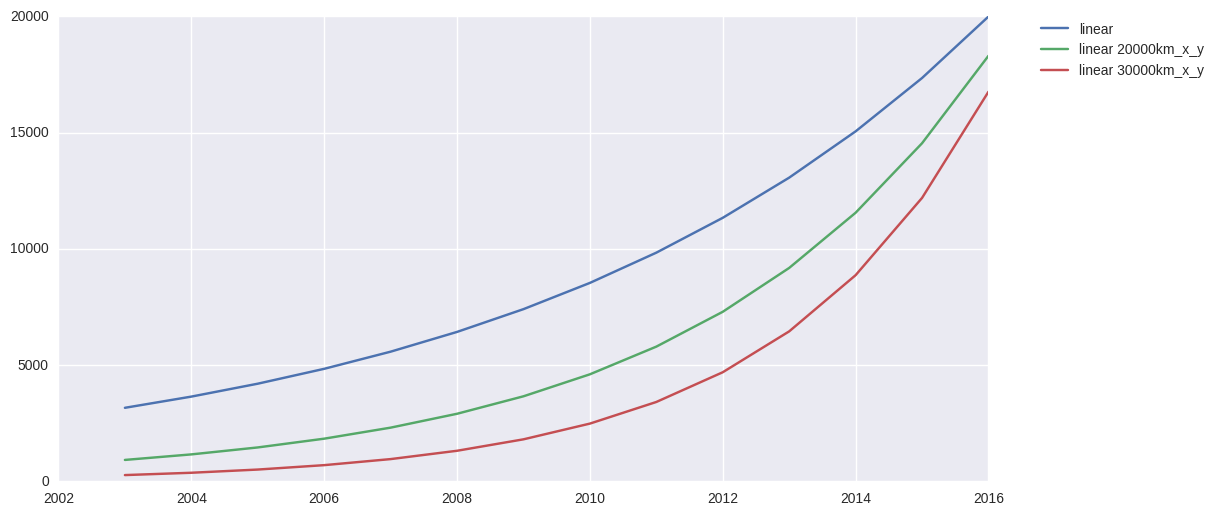

In [21]:

def calc_values(model, year, brand, car_model, vehicle, gearbox, fuel, powerPS, km, not_repaired_damage):
    sample = [year
          , powerPS
          , km
          , 1 # month
          , 35 # namelen
          , les['gearbox'].transform([gearbox])
          , les['notRepairedDamage'].transform([not_repaired_damage])
          , les['model'].transform([car_model])
          , les['brand'].transform([brand])
          , les['fuelType'].transform([fuel])
          , les['vehicleType'].transform([vehicle])]
    s_predict = np.expm1(model.predict([sample]))
    return s_predict

# [nan 'coupe' 'suv' 'kleinwagen' 'limousine' 'cabrio' 'bus' 'kombi' 'andere']
vw1 = calc_values(linear, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(linear, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(linear, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(linear, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_linear  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_linear2  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_linear3  = [calc_values(linear, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_linear, label='linear')
plt.plot(r, values_linear2, label='linear 20000km_x_y')
plt.plot(r, values_linear3, label='linear 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## L1 regularized LR


Variance score: 0.56
kilometer                -0.000010
monthOfRegistration       0.000000
gearbox_feat             -0.000000
notRepairedDamage_feat    0.000000
brand_feat                0.000000
fuelType_feat             0.000000
vehicleType_feat         -0.000000
model_feat                0.000039
namelen                   0.004116
powerPS                   0.009946
yearOfRegistration        0.035016
dtype: float64
0.784970313175
rmse on validation set 0.785621890172


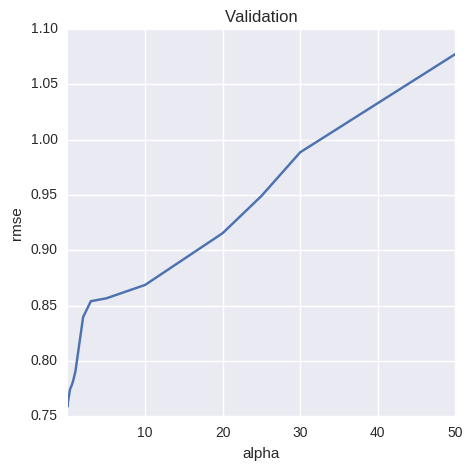

In [22]:

alphas = [0.005,0.05, 0.1, 0.3, 0.5, 0.7, 1, 2, 3, 5, 10, 20, 25, 30, 50]
cv_lasso = [cv_rmse(Lasso(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_lasso = Lasso(alpha = cv_lasso.min()).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_lasso.score(X_val, y_val))

coef = pd.Series(model_lasso.coef_, index = labeled.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_val - model_lasso.predict(X_val))**2)))
print("rmse on validation set", cv_rmse(model_lasso, X_val, y_val).mean())

# Last version results:
# 0.707839916347
# rmse on validation set 0.708803418524


#### Predicting samples

[ 13657.66095189]
[ 21190.61669916]
[ 8713.96957411]
[ 17511.27636962]


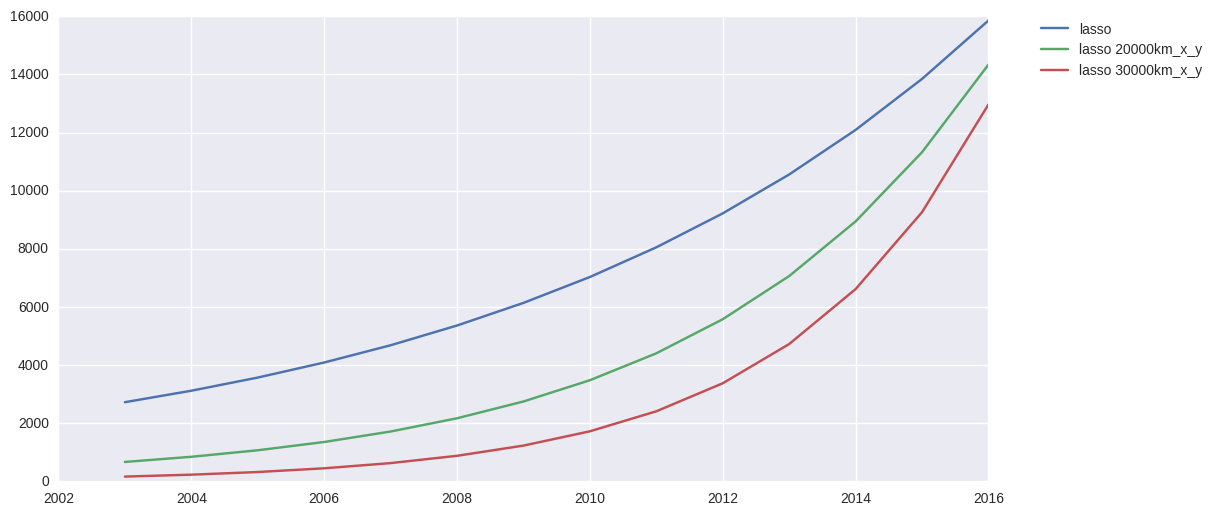

In [23]:
vw1 = calc_values(model_lasso, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_lasso, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_lasso, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_lasso, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_lasso  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_lasso2  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_lasso3  = [calc_values(model_lasso, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_lasso, label='lasso')
plt.plot(r, values_lasso2, label='lasso 20000km_x_y')
plt.plot(r, values_lasso3, label='lasso 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## L2 regularized LR

Variance score: 0.59
gearbox_feat             -0.119231
vehicleType_feat         -0.062360
model_feat               -0.000453
kilometer                -0.000009
brand_feat                0.003663
namelen                   0.005453
powerPS                   0.009664
monthOfRegistration       0.017448
fuelType_feat             0.019499
yearOfRegistration        0.053656
notRepairedDamage_feat    0.109430
dtype: float64
0.761230496811
rmse on validation set 0.761296452477


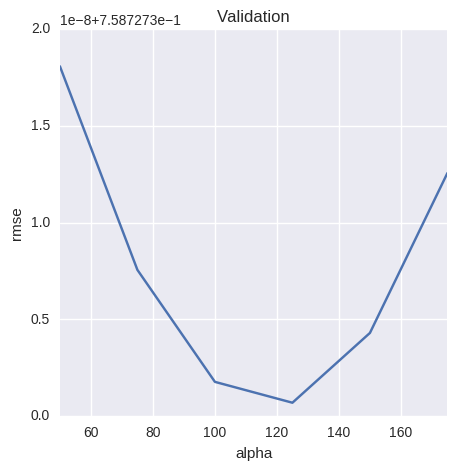

In [24]:

alphas = [ 50, 75, 100, 125, 150, 175]
cv_ridge = [cv_rmse(Ridge(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation", figsize=(5,5))
plt.xlabel("alpha")
plt.ylabel("rmse")

model_ridge = Ridge(alpha = 100).fit(X_train, y_train)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_ridge.score(X_val, y_val))

coef = pd.Series(model_ridge.coef_, index = labeled.iloc[:,1:].columns)

imp_coef = pd.concat([coef.sort_values()])

print(imp_coef)

print(np.sqrt(np.mean((y_val - model_ridge.predict(X_val))**2)))
print("rmse on validation set", cv_rmse(model_ridge, X_val, y_val).mean())

# Last version results:
# 0.639334838313
# rmse on validation set 0.639555431574


#### Predicting samples

[ 17291.5637499]
[ 18867.22115864]
[ 8193.34479952]
[ 14248.58626641]


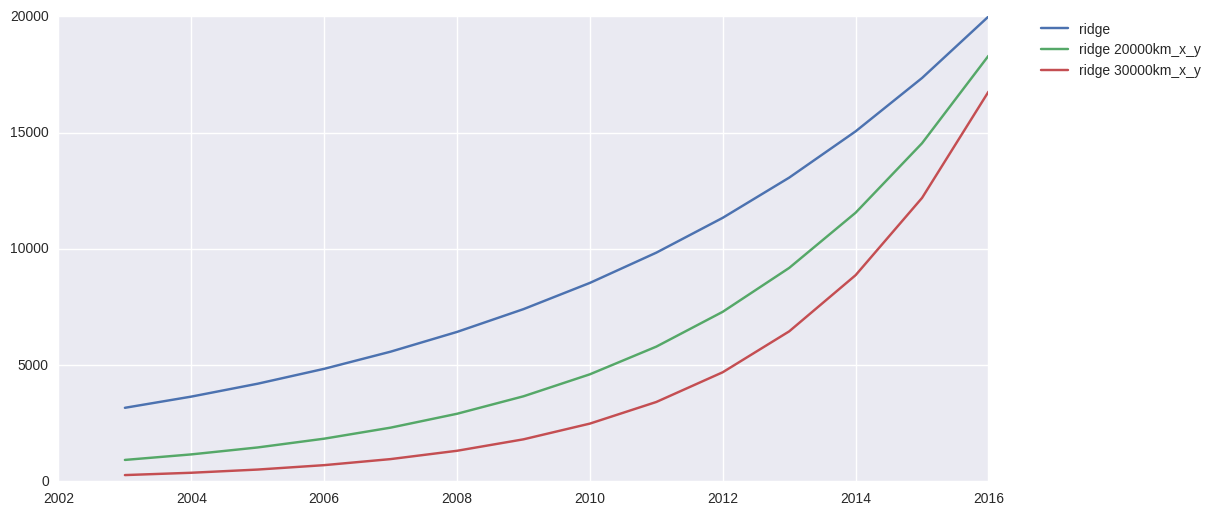

In [25]:
vw1 = calc_values(model_ridge, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(model_ridge, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(model_ridge, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(model_ridge, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

values_ridge  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
values_ridge2  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 2 * (2017-y), 'nein') for y in r]
values_ridge3  = [calc_values(model_ridge, y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * 3 * (2017-y), 'nein') for y in r]
plt.plot(r, values_ridge, label='ridge')
plt.plot(r, values_ridge2, label='ridge 20000km_x_y')
plt.plot(r, values_ridge3, label='ridge 30000km_x_y')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## Random forests

In [26]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators = 10)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [27]:
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % forest.score(X_val, y_val))

print(np.sqrt(np.mean((y_val - forest.predict(X_val))**2)))
print("rmse on validation set", cv_rmse(forest, X_val, y_val).mean())

# Last version results
# Variance score: 0.88
# 0.391895988852
# rmse on validation set 0.426248010639


Variance score: 0.85
0.453904735007
rmse on validation set 0.471795714072


#### Predicting samples

[ 12584.22715763]
[ 16520.71483268]
[ 2421.76810195]
[ 44922.72115179]


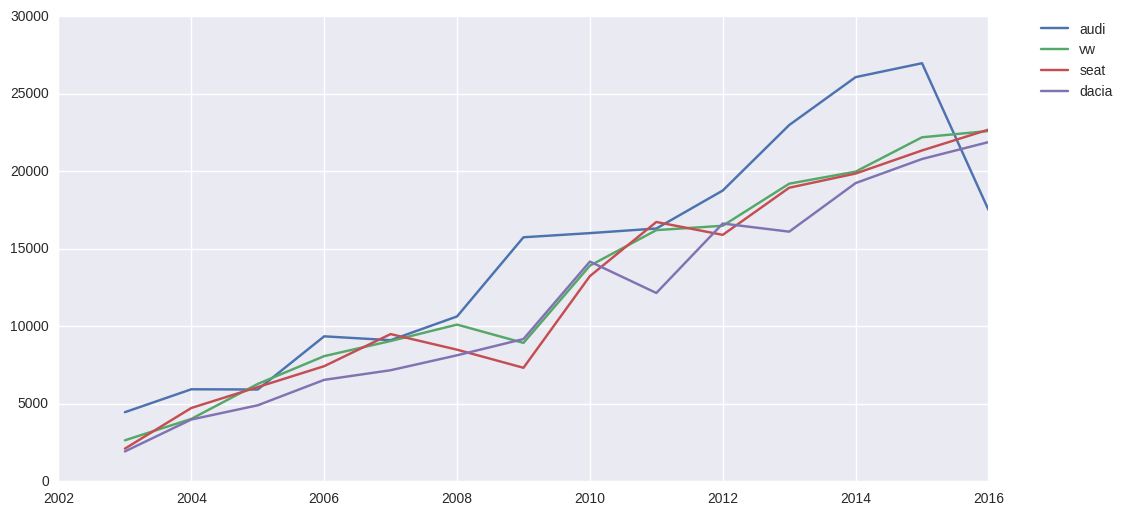

In [28]:
vw1 = calc_values(forest, 2016, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 105, 10000, 'nein')
bmw  = calc_values(forest, 2016, 'bmw', '3er', 'limousine', 'manuell', 'diesel', 150, 10000, 'nein')
fiat  = calc_values(forest, 2016, 'fiat', 'punto', 'kleinwagen', 'manuell', 'benzin', 60, 10000, 'nein')
vw2 = calc_values(forest, 2016, 'volkswagen', 'tiguan', 'suv', 'manuell', 'diesel', 130, 10000, 'nein')

print(vw1)
print(bmw)
print(fiat)
print(vw2)

#values_forest = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year * (2017-y), 'nein') for y in r]
#values_forest2 = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year* 2 * (2017-y), 'nein') for y in r]
#values_forest3 = [calc_values(forest     , y, 'volkswagen', 'touran', 'bus', 'manuell', 'diesel', 120, km_year* 3 * (2017-y), 'nein') for y in r]

values_forest  = [calc_values(forest, y, 'audi', 'a3', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_forest4 = [calc_values(forest, y, 'volkswagen', 'golf', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_forest5 = [calc_values(forest, y, 'seat', 'ibiza', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]
values_forest6 = [calc_values(forest, y, 'dacia', 'logan', 'coupe', 'manuell', 'diesel', 140, km_year * (2017-y), 'nein') for y in r]


plt.plot(r, values_forest, label='audi')
plt.plot(r, values_forest4, label='vw')
plt.plot(r, values_forest5, label='seat')
plt.plot(r, values_forest6, label='dacia')

#plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Conclusions

I've tried to play with as much stuff as I could with this dataset in order to understand the very basic topics about:

* data interpretation and selection
* feature selection and labeling
* data visualization
* very rough ML algorithms application

There's very much to improve both in how I managed all these steps and in the different outcomes of the predictions on the sale price. I'll experiment a bit more in the next few days, then I'll move on another dataset to learn more.
